In [1]:
import pandas as pd     # Se carga la Libreria de pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
sns.set(style="darkgrid")
sns.set(font_scale=0.9)
pd.options.mode.copy_on_write = True
import requests

In [2]:
df_lesiones= pd.read_excel('data/lesiones.xlsx', sheet_name=None)

In [3]:
print(df_lesiones.keys())

dict_keys(['HECHOS', 'DICCIONARIO_HECHOS', 'VICTIMAS', 'DICCIONARIO_VICTIMAS'])


In [4]:
df_hechos_lesiones= df_lesiones['HECHOS']               # Se carga el dataset de "Hechos de Lesiones"
df_victimas_lesiones= df_lesiones['VICTIMAS']           # Se carga el dataset de "Victimas de Lesiones"

In [5]:
# Se carga el mapa de Buenos Aires
url_caba = "https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson"
gdf_caba = gpd.read_file(url_caba)

#### `Analisis del dataSet "Hechos_Lesionados"`

In [6]:
df_hechos_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23785 entries, 0 to 23784
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     23785 non-null  object 
 1   n_victimas             23785 non-null  int64  
 2   aaaa                   23785 non-null  int64  
 3   mm                     23785 non-null  int64  
 4   dd                     23785 non-null  int64  
 5   fecha                  23785 non-null  object 
 6   hora                   23785 non-null  object 
 7   franja_hora            23780 non-null  object 
 8   direccion_normalizada  23732 non-null  object 
 9   comuna                 23616 non-null  object 
 10  tipo_calle             23785 non-null  object 
 11  otra_direccion         23785 non-null  object 
 12  calle                  12867 non-null  object 
 13  altura                 12771 non-null  float64
 14  cruce                  9407 non-null   object 
 15  ge

In [7]:
df_hechos_lesiones.head(3)

,id,n_victimas,aaaa,mm,dd,fecha,hora,franja_hora,direccion_normalizada,comuna,...,latutid,victima,acusado,participantes,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,9,SD,14,...,-34.559658,CICLISTA,SD,CICLISTA-SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,1,SD,8,...,-34.669125,AUTO,SD,AUTO-SD,SD,x,SD,SD,SD,SD
2,LC-2019-0000063,1,2019,1,1,2019-01-01 00:00:00,02:00:00,2,SD,8,...,-34.677556,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD


Analizando el contenido de las columnos se pudo observar que: 
1. Varias columnas continen la misma informacion como "direccion_normalizada, otra direccion, calle" 
2. Las columnas "calle, altura, cruce, geocodificacion_CABA" no son necesarias para este analisis
3. Las columnas "moto, auto, transporte_publico, camion, ciclista" solo muestran cuales son los tipos de transporte involucrados (acusado, victima)
4. El nombre de la columna "latutid" esta mal escrito

Por lo tanto todas estan culumnas seran eliminadas el dataset y tambien se modificara el nombre de la columna "latutid"

In [8]:
# Eliminar columnas innecesarias
df_hechos_lesiones= df_hechos_lesiones.drop(['otra_direccion','calle','altura','cruce','geocodificacion_CABA',
                                             'moto','auto','transporte_publico','camion','ciclista', 'franja_hora'], axis=1) 
# cambiar normbre de la columna
df_hechos_lesiones= df_hechos_lesiones.rename(columns={'latutid': 'latitud'}) 

In [9]:
df_hechos_lesiones.isnull().sum()

id                         0
n_victimas                 0
aaaa                       0
mm                         0
dd                         0
fecha                      0
hora                       0
direccion_normalizada     53
comuna                   169
tipo_calle                 0
longitud                 262
latitud                  262
victima                    0
acusado                    0
participantes              0
gravedad                   0
dtype: int64

Se puede observar que hay columnas comuna, longitud. latitud, direccion y franja_hora tienes valores nulos.

In [10]:
df_hechos_lesiones[df_hechos_lesiones['comuna'].isnull()].head(3)

,id,n_victimas,aaaa,mm,dd,fecha,hora,direccion_normalizada,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
252,LC-2019-0687058,1,2019,1,11,2019-01-11 00:00:00,09:20:00,"PAZ, GRAL. AV. y ACHA, MARIANO, GRAL.",NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
253,LC-2019-0688515,1,2019,1,11,2019-01-11 00:00:00,16:58:00,DEL LIBERTADOR AV. 100,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD
274,LC-2019-0757409,1,2019,1,12,2019-01-12 00:00:00,06:45:00,TRONADOR y GIRIBONE,NaN,SD,NaN,NaN,SD,SD,SD-SD,SD


Al filtrar los valores nulos de la columna "comuna" se puede notar tambien tiene valoresde longitud y latitud, por lo tanto no nos sirven para nuestra analisis

In [11]:
df_hechos_lesiones= df_hechos_lesiones.dropna(subset=['comuna']) # Elimina filas con comuna nulas
df_hechos_lesiones= df_hechos_lesiones.dropna(subset=['longitud']) # Elimina filas con comuna nulas

In [12]:
df_hechos_lesiones.isnull().sum()

id                       0
n_victimas               0
aaaa                     0
mm                       0
dd                       0
fecha                    0
hora                     0
direccion_normalizada    0
comuna                   0
tipo_calle               0
longitud                 0
latitud                  0
victima                  0
acusado                  0
participantes            0
gravedad                 0
dtype: int64

In [13]:
df_hechos_lesiones['longitud'].value_counts() # Contar los valores

longitud
SD                  1209
-58.500738109269      40
-58.380998330204      35
-58.382233829418      29
-58.500649            27
                    ... 
-58.514577             1
-58.433752             1
-58.44362              1
-58.472563             1
-5829963273            1
Name: count, Length: 13810, dtype: int64

Se observan que day coordenadas a las cuales no tienen el "." Se buscaran estos valores y se le colocara el "."

In [14]:
def  insertar_punto(coordenada):
    coordenada= str(coordenada)
    if len(coordenada)> 2:
        if coordenada[3] != ".":
            coordenada = coordenada[:3] + '.' + coordenada[3:]
    return coordenada

In [15]:
# Insertar el "." en la coordenadas para poder graficarlas
df_hechos_lesiones['longitud']= df_hechos_lesiones['longitud'].apply(insertar_punto)
df_hechos_lesiones['latitud']= df_hechos_lesiones['latitud'].apply(insertar_punto)

In [16]:
df_hechos_lesiones.tail(5)

,id,n_victimas,aaaa,mm,dd,fecha,hora,direccion_normalizada,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
23780,LC-2021-0652849,1,2021,12,31,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,-58.513477158887,-34.659713573880,SD,SD,SD-SD,SD
23781,LC-2021-0652865,2,2021,12,31,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,-58.488326609395,-34.641753304864,SD,SD,SD-SD,SD
23782,LC-2021-0652907,1,2021,12,31,2021-12-31 00:00:00,20:00:00,SD,1,SD,-58.382894,-34.583083,SD,SD,SD-SD,SD
23783,LC-2021-0652921,1,2021,12,31,2021-12-31 00:00:00,22:00:00,LINIERS VIRREY y MORENO,5,CALLE,-58.414532050899,-34.614288229345,MOTO,TRANSPORTE PUBLICO,MOTO-TRANSPORTE PUBLICO,GRAVE
23784,LC-2020-0244615,1,2020,5,17,5/17/2020,21:00:00,SD,SD,SD,-58.29963273,-34.72890716,MOTO,AUTO,MOTO-AUTO,SD


In [17]:
df_hechos_lesiones.duplicated().sum()     # Se cuentan las filas duplicadas

0

Se grafica las columnas "victima, acusado, gravedad" para ver si hay datos iguales escritos en minisculas o mayusculas

C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3380756298.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3380756298.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3380756298.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)


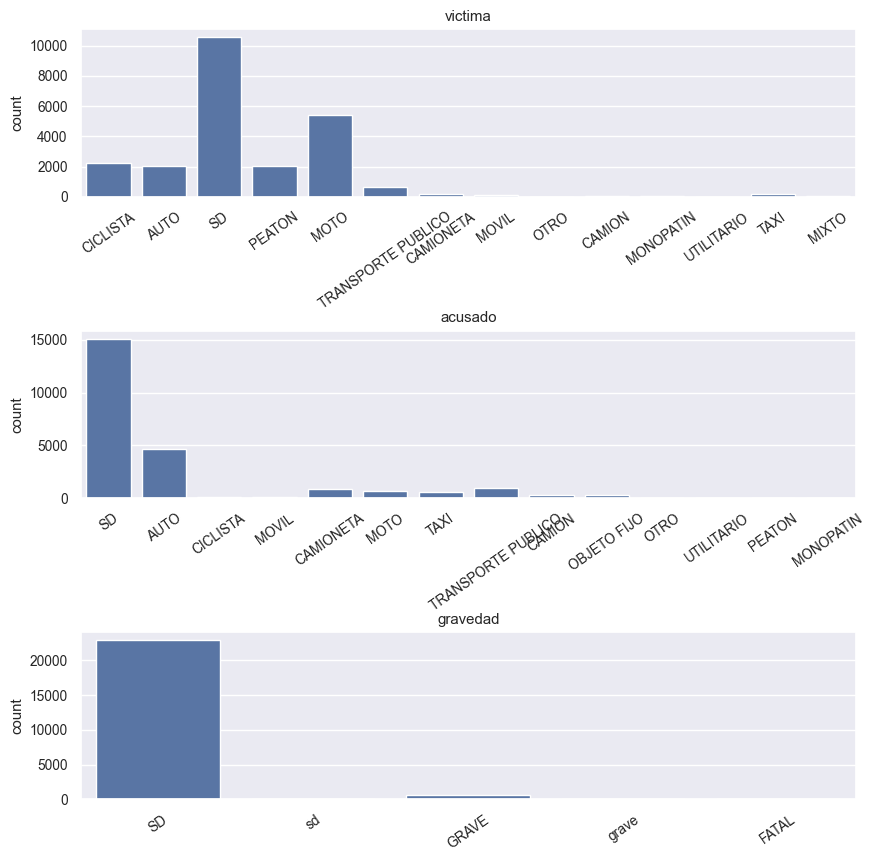

In [18]:
columnas= ['victima', 'acusado', 'gravedad']
fig, ax = plt.subplots(nrows= 3, ncols= 1, figsize= (10,10))
fig.subplots_adjust(hspace= 0.8)
for i, col in enumerate(columnas):
    sns.countplot(data=df_hechos_lesiones, x= col, ax= ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)

Observaciones:
1. La 3 columnas en su mayoria tiene valores "SD" lo que siginifica que no se registraron esos datos en ese accidente
2. Solo la columna gravedad tien datos diferenciados en mayusculas y minusculas (SD, GRAVE).

In [19]:
# Se ponen todos los datos sd y gravedad en mayusculas
df_hechos_lesiones.loc[df_hechos_lesiones['gravedad'] == 'sd','gravedad'] = 'SD'
df_hechos_lesiones.loc[df_hechos_lesiones['gravedad'] == 'grave','gravedad'] = 'GRAVE'

In [20]:
df_hechos_lesiones.head(3)

,id,n_victimas,aaaa,mm,dd,fecha,hora,direccion_normalizada,comuna,tipo_calle,longitud,latitud,victima,acusado,participantes,gravedad
0,LC-2019-0000179,1,2019,1,1,2019-01-01 00:00:00,09:00:00,SD,14,SD,-58.408911,-34.559658,CICLISTA,SD,CICLISTA-SD,SD
1,LC-2019-0000053,1,2019,1,1,2019-01-01 00:00:00,01:55:00,SD,8,SD,-58.44351,-34.669125,AUTO,SD,AUTO-SD,SD
2,LC-2019-0000063,1,2019,1,1,2019-01-01 00:00:00,02:00:00,SD,8,SD,-58.468335,-34.677556,SD,SD,SD-SD,SD


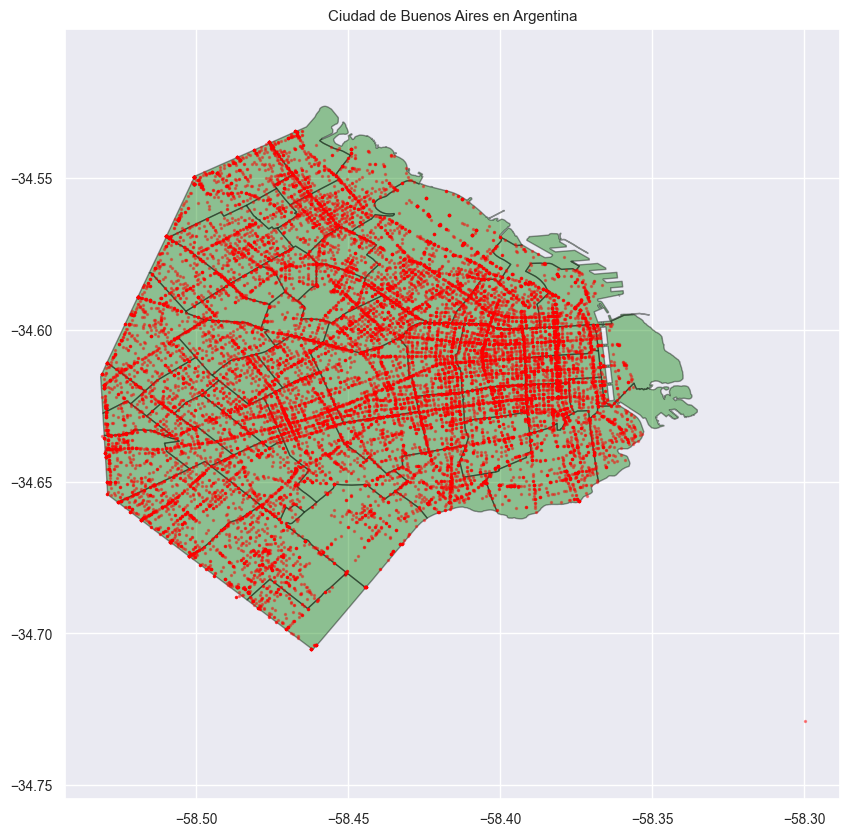

In [21]:
# Se cargan los Puntos geograficos
df_hechos_lesiones_NoSD= df_hechos_lesiones[df_hechos_lesiones['longitud']!= 'SD']
geometry = gpd.points_from_xy(df_hechos_lesiones_NoSD['longitud'], df_hechos_lesiones_NoSD['latitud'], crs="EPSG:4326")
gdf_lesionados = gpd.GeoDataFrame(df_hechos_lesiones_NoSD, geometry=geometry)

# Plotear el mapa de Argentina y la Ciudad Autónoma de Buenos Aires
fig, ax = plt.subplots(figsize=(10, 10))

gdf_caba.plot(ax=ax, color='green', edgecolor='black', alpha=0.4)
gdf_lesionados.plot(ax=ax, color='red', markersize=2, alpha=0.4)
ax.set_title('Ciudad de Buenos Aires en Argentina')
plt.axis('equal')
plt.show()

#### `Analisis del dataSet "Victimas_Lesionados"`

In [24]:
df_victimas_lesiones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27605 entries, 0 to 27604
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ID hecho          27605 non-null  object        
 1   AAA               27605 non-null  int64         
 2   MM                27605 non-null  int64         
 3   DD                27605 non-null  int64         
 4   FECHA             27605 non-null  datetime64[ns]
 5   VEHICULO_VICTIMA  27605 non-null  object        
 6   SEXO              27605 non-null  object        
 7   EDAD_VICTIMA      27605 non-null  object        
 8   GRAVEDAD          27605 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 1.9+ MB


C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3954524368.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3954524368.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)
C:\Users\Familia Velazco\AppData\Local\Temp\ipykernel_20968\3954524368.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)


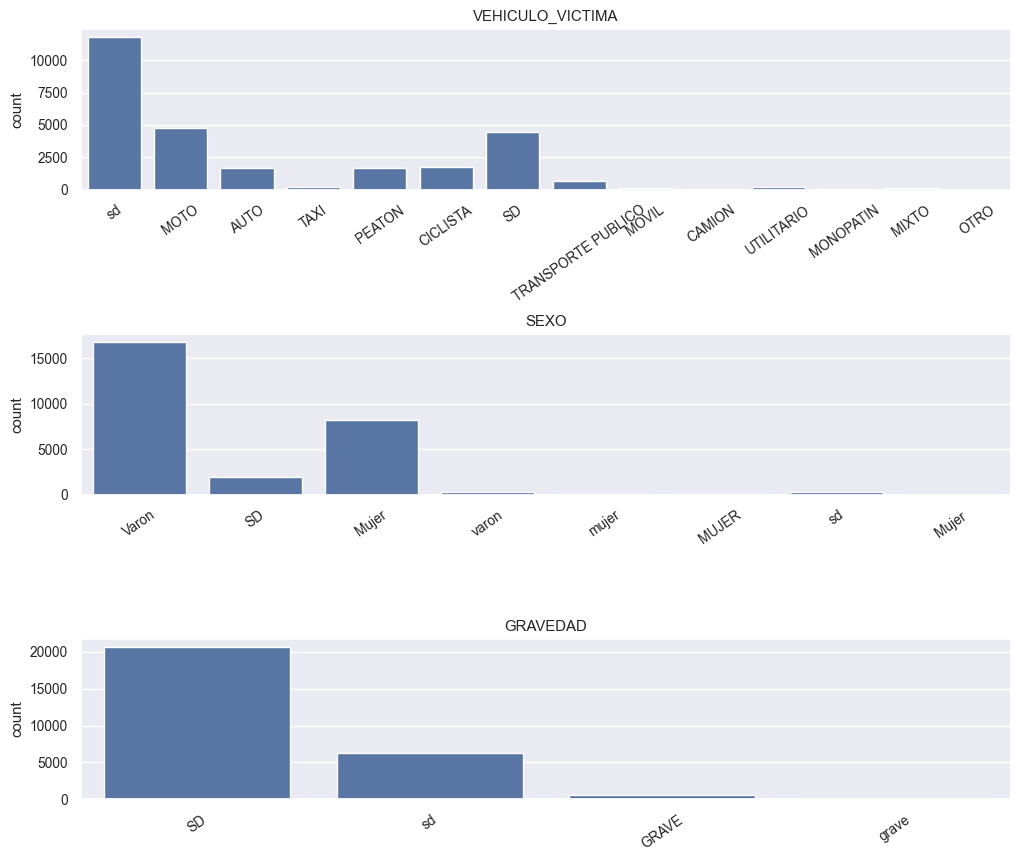

In [34]:
columnas= ['VEHICULO_VICTIMA', 'SEXO', 'GRAVEDAD']
fig, ax = plt.subplots(nrows= 3, ncols= 1, figsize= (12,10))
fig.subplots_adjust(hspace= 0.9)
for i, col in enumerate(columnas):
    sns.countplot(data=df_victimas_lesiones, x= col, ax= ax[i])
    ax[i].set_title(col)
    ax[i].set_xlabel('')
    ax[i].set_xticklabels(ax[i].get_xticklabels(),rotation= 35)

In [31]:
df_victimas_lesiones.isnull().sum()

ID hecho            0
AAA                 0
MM                  0
DD                  0
FECHA               0
VEHICULO_VICTIMA    0
SEXO                0
EDAD_VICTIMA        0
GRAVEDAD            0
dtype: int64